In [3]:
"""Tutorial on how to create a convolutional autoencoder w/ Tensorflow.

Parag K. Mital, Jan 2016
"""
# %% imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import math
from libs.activations import lrelu
from libs.utils import corrupt


In [56]:
# %%
def autoencoder(input_shape=[None, 784],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):
    """Build a deep denoising autoencoder w/ tied weights.

    Parameters
    ----------
    input_shape : list, optional
        Description
    n_filters : list, optional
        Description
    filter_sizes : list, optional
        Description

    Returns
    -------
    x : Tensor
        Input placeholder to the network
    z : Tensor
        Inner-most latent representation
    y : Tensor
        Output reconstruction of the input
    cost : Tensor
        Overall cost to use for training

    Raises
    ------
    ValueError
        Description
    """
    # %%
    # input to the network
    x = tf.placeholder(
        tf.float32, input_shape, name='x')

    # %%
    # Optionally apply denoising autoencoder
    if corruption:
        x_noise = corrupt(x)
    else:
        x_noise = x

    # %%
    # ensure 2-d is converted to square tensor.
    if len(x.get_shape()) == 2:
        x_dim = np.sqrt(x_noise.get_shape().as_list()[1])
        if x_dim != int(x_dim):
            raise ValueError('Unsupported input dimensions')
        x_dim = int(x_dim)
        x_tensor = tf.reshape(
            x_noise, [-1, x_dim, x_dim, n_filters[0]])
    elif len(x_noise.get_shape()) == 4:
        x_tensor = x_noise
    else:
        raise ValueError('Unsupported input dimensions')
    current_input = x_tensor

    # %%
    # Build the encoder
    encoder = []
    shapes = []
    for layer_i, n_output in enumerate(n_filters[1:]):
        n_input = current_input.get_shape().as_list()[3]
        shapes.append(current_input.get_shape().as_list())
        W = tf.Variable(
            tf.random_uniform([
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)))
        b = tf.Variable(tf.zeros([n_output]))
        encoder.append(W)
        output = lrelu(
            tf.add(tf.nn.conv2d(
                current_input, W, strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

#     shapes.append(current_input.get_shape().as_list())
    # %%         
    # add fully connected layer
    # latent size
    print('shapes:', shapes)
    n_z = 30
#     n_input = np.prod(shapes[-1][1:])
    n_input = 4 * 4 * 10
    n_output = n_z
    # flatten convolutional output
    print('cur input:', current_input)
    current_input = tf.reshape(current_input, ((-1, n_input)))
    shapes.append(current_input.get_shape().as_list())
    W = tf.Variable(
            tf.random_uniform(
                [n_input, n_output],
                -1.0 / math.sqrt(n_input),
                1.0 / math.sqrt(n_input)
            )
    )
    b = tf.Variable(tf.zeros([n_output]))
    encoder.append(W)
#     print('n_output:' ,n_output)
#     print('n_input:', n_input)
    print('cur input:', current_input)
    output = tf.nn.tanh(tf.matmul(current_input, W) + b)
    current_input = output
    print('cur input', current_input)
        
    # %%
    # store the latent representation
    z = current_input
    encoder.reverse()
    shapes.reverse()

    print('encoder', encoder)
    
    # %%
    # Build the decoder using the same weights
    for layer_i, shape in enumerate(shapes):
        W = encoder[layer_i]
        # first layer is fully connected
        if layer_i == 0:
            W = tf.transpose(W)
            b = tf.Variable(tf.zeros([W.get_shape().as_list()[-1]]))
            # TODO this output needs to be transposed (or sth) and reshaped
            output = tf.nn.tanh(tf.matmul(current_input, W) + b)
            print('cur input', output)
            output = tf.reshape(output, (-1, 4, 4, 10))
            print('cur input', output)
        # rest is convolutional
        else:
            b = tf.Variable(tf.zeros([W.get_shape().as_list()[-1]]))
            output = lrelu(tf.add(
                tf.nn.conv2d_transpose(
                    current_input, W,
                    tf.pack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
                    strides=[1, 2, 2, 1], padding='SAME'), b))
        current_input = output

    # %%
    # now have the reconstruction through the network
    y = current_input
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x_tensor))

    # %%
    return {'x': x, 'z': z, 'y': y, 'cost': cost}


In [57]:
a = autoencoder()

shapes: [[None, 28, 28, 1], [None, 14, 14, 10], [None, 7, 7, 10]]
cur input: Tensor("lrelu_86/add:0", shape=(?, 4, 4, 10), dtype=float32)
cur input: Tensor("Reshape_56:0", shape=(?, 160), dtype=float32)
cur input Tensor("Tanh_33:0", shape=(?, 30), dtype=float32)
encoder [<tensorflow.python.ops.variables.Variable object at 0x7f2ea420cb38>, <tensorflow.python.ops.variables.Variable object at 0x7f2ea4243828>, <tensorflow.python.ops.variables.Variable object at 0x7f2ea426a588>, <tensorflow.python.ops.variables.Variable object at 0x7f2ea4385cc0>]
cur input Tensor("Tanh_34:0", shape=(?, 160), dtype=float32)
cur input Tensor("Reshape_57:0", shape=(?, 4, 4, 10), dtype=float32)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
shapes: [[None, 28, 28, 1], [None, 14, 14, 10], [None, 7, 7, 10]]
cur input: Tensor("lrelu_98/add:0", shape=(?, 4, 4, 10), dtype=float32)
cur input: Tensor("Reshape_62:0", shape=(?, 160), dtype=float32)
cur input Tensor("Tanh_37:0", shape=(?, 30), dtype=float32)
encoder [<tensorflow.python.ops.variables.Variable object at 0x7f2e99e871d0>, <tensorflow.python.ops.variables.Variable object at 0x7f2e99e78978>, <tensorflow.python.ops.variables.Variable object at 0x7f2e99e78f98>, <tensorflow.python.ops.variables.Variable object at 0x7f2ea41707b8>]
cur input Tensor("Tanh_38:0", shape=(?, 160), dtype=float32)
cur input Tensor("Reshape_63:0", shape=(?, 4, 4, 10), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
0 13652.9
1 10090.7
2 9838.72
3 8668.55
4 8866.83
5 84

ValueError: total size of new array must be unchanged

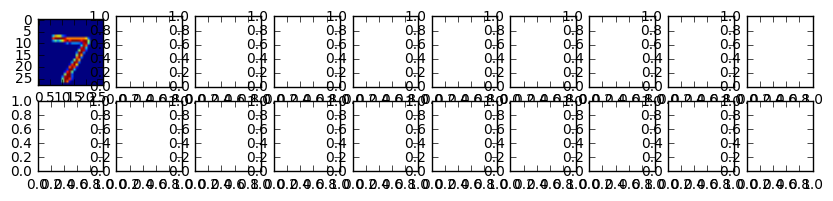

In [59]:
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt

# %%
# load MNIST as before
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
mean_img = np.mean(mnist.train.images, axis=0)
ae = autoencoder()

# %%
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data
batch_size = 100
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optimizer, feed_dict={ae['x']: train})
    print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

# %%
# Plot example reconstructions
n_examples = 10
test_xs, _ = mnist.test.next_batch(n_examples)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
print(recon.shape)
fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (28, 28)))
    axs[1][example_i].imshow(recon[example_i])
#     axs[1][example_i].imshow(
#         np.reshape(
#             np.reshape(recon[example_i, ...], (784,)) + mean_img,
#             (28, 28)))
fig.show()
plt.draw()


In [85]:

# %%
# Fit all training data
batch_size = 100
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optimizer, feed_dict={ae['x']: train})
    print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))


0 7825.22
1 7347.62
2 7475.0
3 8068.61
4 8279.06
5 7044.75
6 8388.53
7 7135.83
8 8335.19
9 8013.0


(10, 28, 28, 10)


/home/ira/code/envs/flexi/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


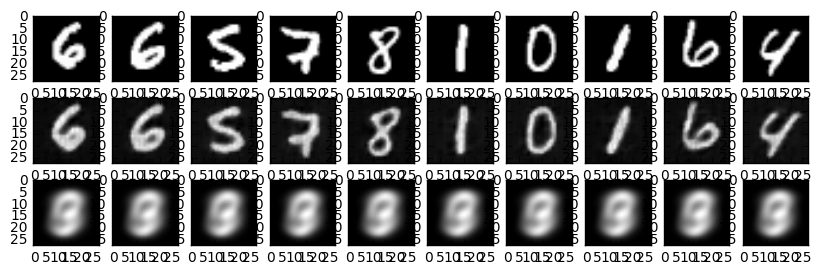

In [86]:
# %%
# Plot example reconstructions
n_examples = 10
test_xs, _ = mnist.test.next_batch(n_examples)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
print(recon.shape)
fig, axs = plt.subplots(3, n_examples, figsize=(10, 3))
for example_i in range(n_examples):
    axs[0][example_i].imshow(
        np.reshape(test_xs[example_i, :], (28, 28)), cmap='gray')
#     axs[1][example_i].imshow(recon[example_i:,:,0])
    axs[1][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i,:,:,1], (784,)) + mean_img,
            (28, 28)), cmap='gray')
    axs[2][example_i].imshow(
        np.reshape(
            np.reshape(recon[example_i,:,:,2] - recon[example_i,:,:,1], (784,)) + mean_img,
            (28, 28)), cmap='gray')
fig.show()
plt.draw()

In [70]:
recon[example_i, ...].shape

(28, 28, 10)